In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

---
## Загрузка изображения

In [2]:
img = cv2.imread('periodic_noise.JPG', cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap='gray')
plt.title('Исходное изображение с периодическим шумом', fontweight='bold')
plt.axis('off')
plt.show()

print(f'Размер: {img.shape}')

Размер: (594, 787)


In [3]:
# Преобразование Фурье
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude = 20 * np.log(np.abs(fshift) + 1)

plt.imshow(magnitude, cmap='gray')
plt.title('Амплитудный спектр Фурье', fontweight='bold')
plt.axis('off')
plt.show()

print('Яркие точки на спектре — это частоты периодического шума')

Яркие точки на спектре — это частоты периодического шума


---
## Удаление периодического шума

In [4]:
# Автоматический поиск пиков шума
peaks = peak_local_max(magnitude, min_distance=20, threshold_abs=150, exclude_border=20)

print(f'Найдено пиков: {len(peaks)}')

# Визуализация пиков
plt.imshow(magnitude, cmap='gray')
plt.plot(peaks[:, 1], peaks[:, 0], 'r+', markersize=8)
plt.title(f'Обнаруженные пики шума ({len(peaks)} шт.)', fontweight='bold')
plt.axis('off')
plt.show()

Найдено пиков: 328


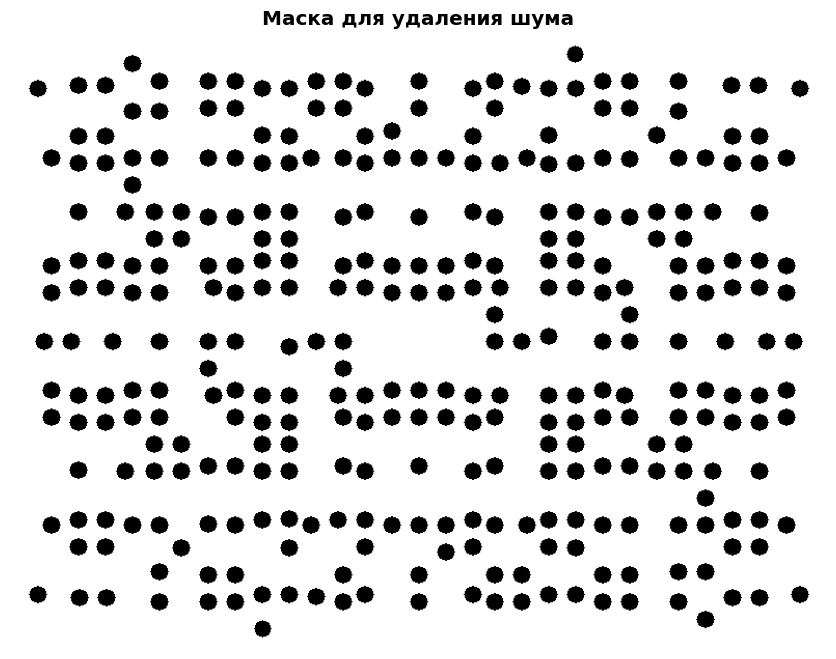

In [5]:
# Создание маски (notch-фильтр)
rows, cols = img.shape
crow, ccol = rows // 2, cols // 2
mask = np.ones((rows, cols), dtype=np.uint8)

radius = 8  # Радиус вырезаемой области

for coord in peaks:
    y, x = coord
    
    # Пропускаем центральную область (DC компонента)
    if abs(y - crow) < 15 and abs(x - ccol) < 15:
        continue
    
    # Рисуем круг на маске
    cv2.circle(mask, (x, y), radius, 0, -1)
    # Симметричная точка
    cv2.circle(mask, (cols - x, rows - y), radius, 0, -1)

plt.imshow(mask, cmap='gray')
plt.title('Маска для удаления шума', fontweight='bold')
plt.axis('off')
plt.show()

Пики шума удалены из спектра!


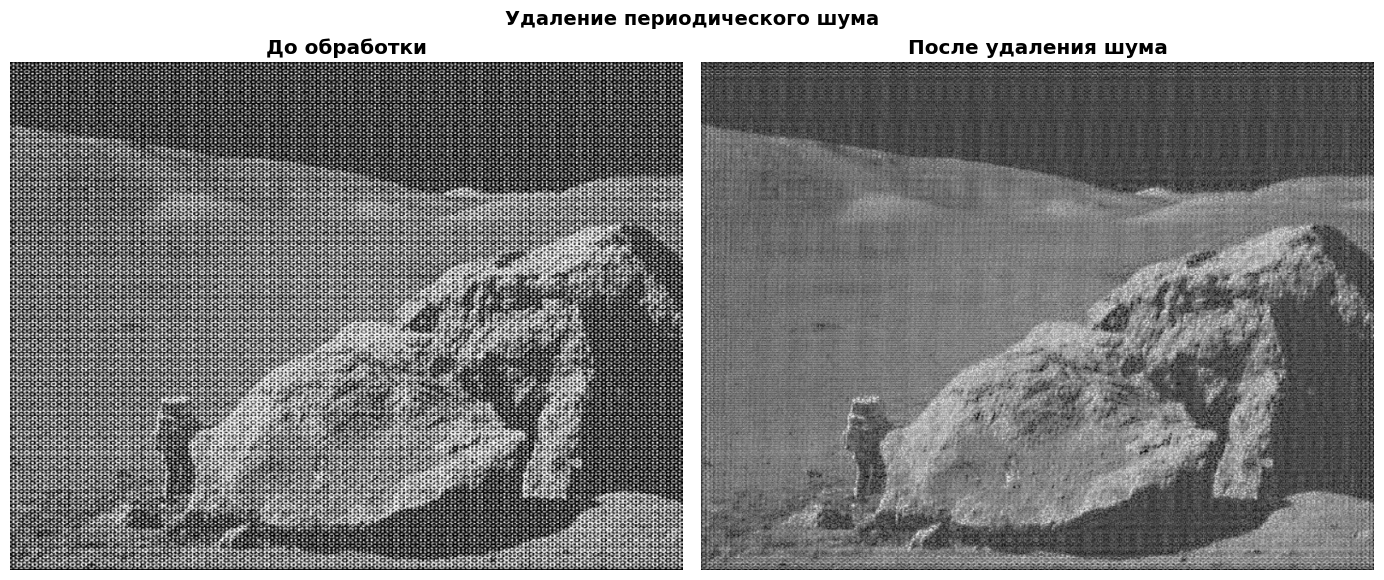

Периодический шум удалён!


In [6]:
# Применение маски
fshift_filtered = fshift * mask

# Спектр после фильтрации
magnitude_filtered = 20 * np.log(np.abs(fshift_filtered) + 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(magnitude, cmap='gray')
axes[0].set_title('Спектр ДО фильтрации', fontweight='bold')
axes[0].axis('off')
axes[1].imshow(magnitude_filtered, cmap='gray')
axes[1].set_title('Спектр ПОСЛЕ фильтрации', fontweight='bold')
axes[1].axis('off')
plt.suptitle('Сравнение спектров', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print('Пики шума удалены из спектра!')

# Обратное преобразование
f_ishift = np.fft.ifftshift(fshift_filtered)
img_filtered = np.abs(np.fft.ifft2(f_ishift))
img_filtered = np.clip(img_filtered, 0, 255).astype(np.uint8)

# Результат
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(img, cmap='gray')
axes[0].set_title('До обработки', fontweight='bold')
axes[0].axis('off')

axes[1].imshow(img_filtered, cmap='gray')
axes[1].set_title('После удаления шума', fontweight='bold')
axes[1].axis('off')

plt.suptitle('Удаление периодического шума', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print('Периодический шум удалён!')

---
## Высокочастотная фильтрация (Гаусс)

In [7]:
def gaussian_highpass(shape, sigma):
    """Гауссов высокочастотный фильтр"""
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2
    
    x = np.arange(cols) - ccol
    y = np.arange(rows) - crow
    X, Y = np.meshgrid(x, y)
    
    distance = np.sqrt(X**2 + Y**2)
    lowpass = np.exp(-(distance**2) / (2 * sigma**2))
    highpass = 1 - lowpass
    
    return highpass

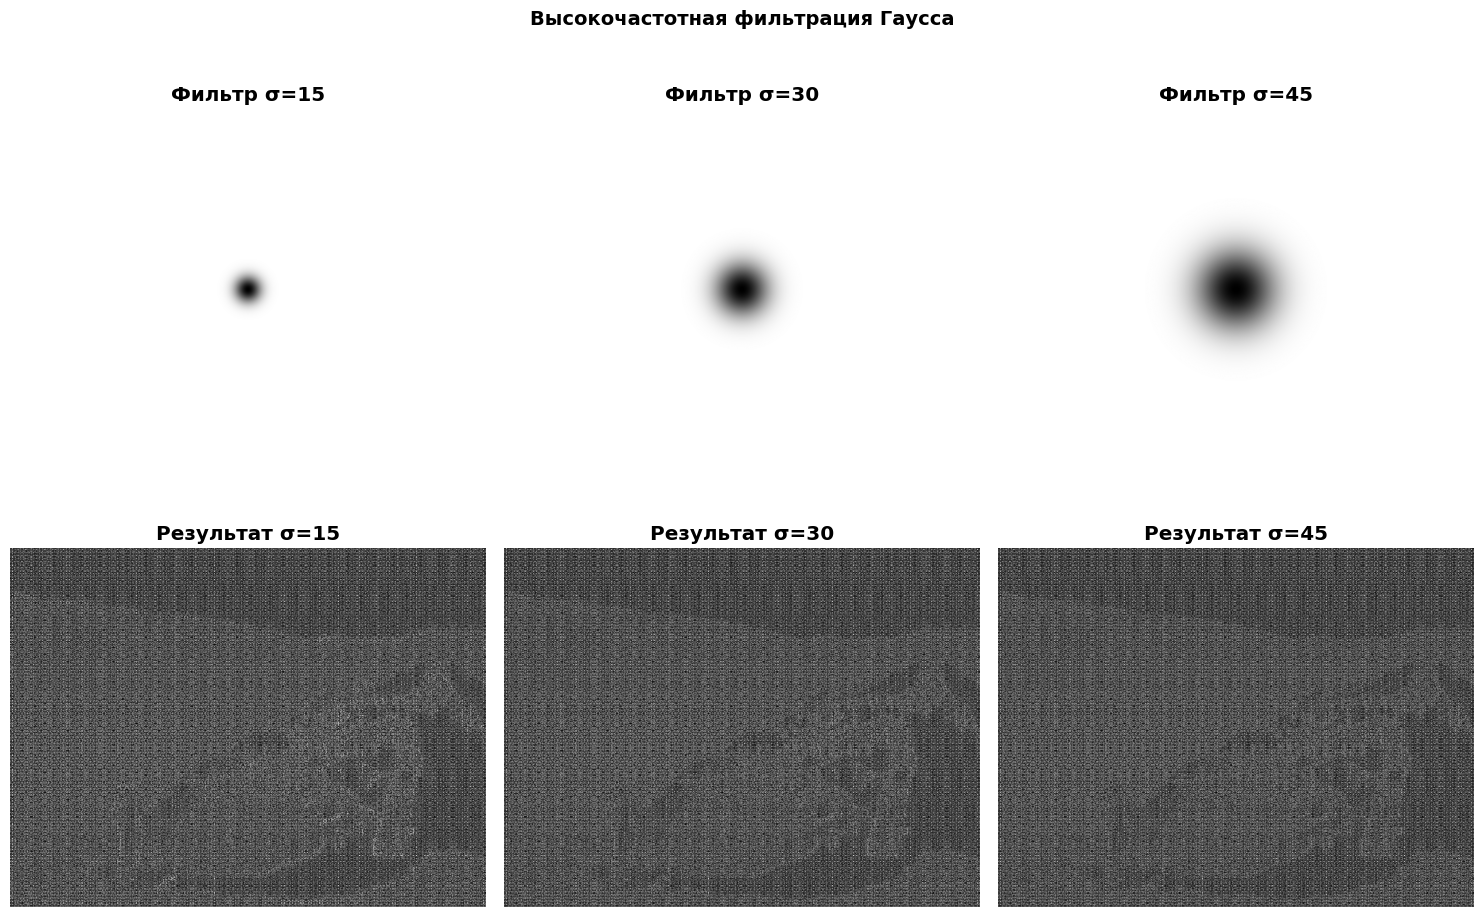

In [8]:
# Тестирование разных sigma
sigmas = [15, 30, 45]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Новое FFT для исходного изображения
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)

for idx, sigma in enumerate(sigmas):
    hp_filter = gaussian_highpass(img.shape, sigma)
    
    # Фильтр
    axes[0, idx].imshow(hp_filter, cmap='gray')
    axes[0, idx].set_title(f'Фильтр σ={sigma}', fontweight='bold')
    axes[0, idx].axis('off')
    
    # Результат
    filtered = fshift * hp_filter
    result = np.abs(np.fft.ifft2(np.fft.ifftshift(filtered)))
    
    axes[1, idx].imshow(result, cmap='gray')
    axes[1, idx].set_title(f'Результат σ={sigma}', fontweight='bold')
    axes[1, idx].axis('off')

plt.suptitle('Высокочастотная фильтрация Гаусса', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()